<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/nice_plot/PINN_LaPlace2D_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [298]:
!pip install git+https://github.com/dr-aheydari/SoftAdapt.git

  Cloning https://github.com/dr-aheydari/SoftAdapt.git to /tmp/pip-req-build-zo27gu0d
  Running command git clone --filter=blob:none --quiet https://github.com/dr-aheydari/SoftAdapt.git /tmp/pip-req-build-zo27gu0d
  Resolved https://github.com/dr-aheydari/SoftAdapt.git to commit 5fc955f424052cc94824d7ba9d7e7ea564c8e254
  Preparing metadata (setup.py) ... done


In [299]:
from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

#Network

In [300]:
import torch
import torch.nn as nn

class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class FNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 2,
        num_layers: int = 4,
        num_neurons = [256,128,64,32,16],
        dropout_rate: float = 0.5,  # Add dropout rate as a parameter
        act: nn.Module = SineActivation(),
    ) -> None:
        """Basic neural network architecture with linear layers

        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()

        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons[0]))

        # hidden layers with linear layer and activation
        for i in range(num_layers):
            layers.extend([nn.Linear(num_neurons[i], num_neurons[i] if i is len(num_neurons)-1 else num_neurons[i+1]),act])
            # Add dropout after every other linear layer
            #if i % 2 == 1:
            #  layers.extend([nn.Linear(num_neurons, num_neurons),act])
            #else:
            #  layers.extend([nn.Linear(num_neurons, num_neurons), nn.Dropout(dropout_rate) ,act])


        # output layer
        layers.append(nn.Linear(num_neurons[-1], 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

#network

# Example usage:
"""
model = LinearNN()
input_tensor = torch.randn((10, 2))  # Example input with batch size 10 and 2 features
output = model(input_tensor)

print("Input shape:", input_tensor)
print("Output shape:", output)"""

'\nmodel = LinearNN()\ninput_tensor = torch.randn((10, 2))  # Example input with batch size 10 and 2 features\noutput = model(input_tensor)\n\nprint("Input shape:", input_tensor)\nprint("Output shape:", output)'

#PINN Loss

In [301]:
import torch.nn.functional as F
import torch.autograd.functional as autograd

def data_loss(predicted_data, target_data): #data has to be in z=0, 0<x<L
        #target data is obtained using behaviour function
        #return F.mse_loss(predicted_data, target_data)
        #criterion=torch.nn.L1Loss()
        criterion=torch.nn.SmoothL1Loss()
        #criterion=torch.nn.MSELoss()
        #target_data = target_data.view(-1, 1)  # Assuming you want a column vector
        predicted_data = predicted_data.view(-1,1)
        #print("TARGET: ",target_data.shape)
        #print("PREDICTED :",predicted_data.shape)
        return criterion(predicted_data, target_data)

def boundary_condition_loss(boundary_conditions,output):
    # Customize based on your specific boundary conditions
    # Example: Dirichlet boundary condition u(0, t) = g(t)
    #loss_bc = F.mse_loss(boundary_conditions['bc1'], torch.zeros_like(output)) + F.mse_loss(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    # instead of 0 it will be an array of zeros with the same length as the number of points we decide to use to calculate the loss
    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    #criterion=torch.nn.MSELoss()
    loss_bc = criterion(boundary_conditions['bc1'], torch.zeros_like(output)) + criterion(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    return loss_bc

def periodic_boundary_loss(boundary_conditions):
    # Customize based on your specific boundary conditions
    # Example: Dirichlet boundary condition u(0, t) = g(t)
    #loss_bc = F.mse_loss(boundary_conditions['bc1'], torch.zeros_like(output)) + F.mse_loss(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    # instead of 0 it will be an array of zeros with the same length as the number of points we decide to use to calculate the loss

    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    #criterion=torch.nn.MSELoss()
    loss_bc = criterion(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    return loss_bc

def bottom_velocity_boundary_loss(boundary_conditions,output):

    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    #criterion=torch.nn.MSELoss()
    loss_bc = criterion(boundary_conditions['bc1'], torch.zeros_like(output))
    return loss_bc

def object_velocity_boundary_loss(boundary_conditions,output):

    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    #criterion=torch.nn.MSELoss()
    loss_bc = criterion(boundary_conditions['bc3'], torch.zeros_like(output))
    return loss_bc

def pde_loss(model,input_data): #here input_data has to be in -h(x)<x2<0
#
#    # Forward pass to get the function values
#    output = model(input_data)
#    pde_residuals=[]
#    for o,d in zip(output,input_data):
      # Compute the Hessian matrix
#      hessian = compute_hessian(o, d)

      # Extract elements corresponding to (0, 0) and (1, 1)
      #hessian_00 = hessian[0, 0]
      #hessian_11 = hessian[1, 1]

      #pde_residuals.append(hessian_00+hessian_11)
    pde_residuals_tensor = compute_hessian(model,input_data)
    #print(f"{hessians.sum(dim=1)}")
    #pde_residuals_tensor = hessians.sum(dim=1)
    #pde_residuals_tensor = torch.cat([residual.unsqueeze(0) for residual in pde_residuals])

    # Use torch.zeros_like with the tensor
    #return F.mse_loss(pde_residuals_tensor, torch.zeros_like(pde_residuals_tensor))
    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    #criterion=torch.nn.MSELoss()
    return criterion(pde_residuals_tensor, torch.zeros_like(pde_residuals_tensor))

def  body_boundary_loss(boundary_conditions,output):
    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    #criterion=torch.nn.MSELoss()
    loss_b = criterion(boundary_conditions['bc_body_b'], torch.zeros_like(output))
    loss_t = criterion(boundary_conditions['bc_body_t'], torch.zeros_like(output))
    loss_r = criterion(boundary_conditions['bc_body_r'], torch.zeros_like(output))
    loss_l = criterion(boundary_conditions['bc_body_l'], torch.zeros_like(output))

    loss_body=loss_b+loss_t+loss_r+loss_l
    return loss_body

def compute_bc1(model,  x1,x2):

    x1_tensor = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
    x2_tensor = torch.tensor(x2, dtype=torch.float32 , requires_grad=True)

    # Concatenate x1 and x2 to form the input tensor
    input_tensor = torch.stack([x1_tensor, x2_tensor], dim=1)

    # Forward pass through the model
    output = model(input_tensor)

    # Compute the gradient with respect to x2
    grad_x2 = torch.autograd.grad(output, input_tensor,grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 1]

    # Initialize a list to store the gradients for each element of x2_tensor
    #gradients_x2 = []

    # Compute the gradient for each element of output with respect to x2_tensor
    #for i in range(len(output)):
    #    grad_x2_element = torch.autograd.grad(output[i], x2_tensor[i], create_graph=True)[0]
    #    gradients_x2.append(grad_x2_element)

    # Stack the gradients into a tensor
    #grad_x2 = torch.stack(gradients_x2, dim=0)

    #print(f'Gradient bottom: {grad_x2}')
    return grad_x2

def compute_bc2(model, input_tensor):

    # Forward pass through the model
    output = model(input_tensor)

    #print(f'output: {output}')
    return output

def compute_bc3(model,  x1,x2):

  x1_tensor = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
  x2_tensor = torch.tensor(x2, dtype=torch.float32 , requires_grad=True)

  # Concatenate x1 and x2 to form the input tensor
  input_tensor = torch.stack([x1_tensor, x2_tensor], dim=1)

  # Forward pass through the model
  output = model(input_tensor)

  # Compute the gradient with respect to x2
  grad_x1 = torch.autograd.grad(output, input_tensor,grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 0]

  # Initialize a list to store the gradients for each element of x2_tensor
  #gradients_x2 = []

  # Compute the gradient for each element of output with respect to x2_tensor
  #for i in range(len(output)):
  #    grad_x2_element = torch.autograd.grad(output[i], x2_tensor[i], create_graph=True)[0]
  #    gradients_x2.append(grad_x2_element)

  # Stack the gradients into a tensor
  #grad_x2 = torch.stack(gradients_x2, dim=0)

  #print(f'Gradient bottom: {grad_x2}')
  return grad_x1

#def compute_hessian(output, input_data):
#    hessian = autograd.hessian(lambda x: output, input_data)
#    return hessian

def compute_hessian(model, input_data):
    output = model(input_data)
    # Calculate the first-order gradients
    gradients = torch.autograd.grad(output, input_data, grad_outputs=torch.ones_like(output), create_graph=True)[0]

    # Calculate the second-order gradients for each element of input_data
    hessian = torch.zeros_like(input_data)
    for i in range(input_data.shape[1]):
      hessian[:, i] = torch.autograd.grad(gradients[:, i], input_data, grad_outputs=torch.ones_like(gradients[:, i]), create_graph=True)[0][:, i]

    return hessian.sum(dim=1)
#x1 and x2 have to represent the points we want to apply the constraints

#boundary_conditions = {
#    'bc1': compute_bc1(model, x1, -1),   # at x2=-1 the grad perpendicular to the bottom is null
#    'bc2_0': compute_bc2(model, 0, x2),  # at x1 = 0
#    'bc2_1': compute_bc2(model, 2, x2),  # at x1 = 2
#}

#total_loss = loss_data + loss_bc + loss_pde

#the data we provide to calculate each loss is extremely important. It has to belong to the domain where the constraints/pde/function are applied.

#Functions analytical calculation




In [302]:
import numpy as np
import math
from sklearn.preprocessing import StandardScaler

# General parameters
L = 2.0 # wave/x length
h = 1 # depth
T = 1 # period
H = 0.05 # surface wave amplitude (I chose it arbitrarliy. Check p. 68 HRC)
c = L/T # wave propagation velocity (p. 70 HCR)
k = 2*np.pi/L # wave nr.
w = 2*np.pi/T

t = 0 # we are looking at a snapshot, so t is constant

#initialize scaler
scaler = StandardScaler()

# Analytical solution (HRC p. 75)
def behaviour_func(x):
    return -(H*c/2) * np.cosh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.sin(w*t - k*x[:, 0:1])

def velocity_func(x):

  u= H*c/2 * k * np.cosh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.cos(w*t-k*x[:, 0:1])
  v= -H*c/2 * k * np.sinh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.sin(w*t - k*x[:, 0:1])

  return u,v

#Generate data

In [303]:
def generate_data_function_approximation(size):
    x1 = np.linspace(0, L, size+1, endpoint=False)[1:]

    # Set x2 to zeros
    x2 = np.zeros_like(x1)

    # Create input data by stacking x1, x2
    input_data = np.column_stack((x1, x2))

    # Compute the corresponding function values using the analytical solution
    target_data = behaviour_func(input_data)

    return input_data, target_data

def generate_data_pde_loss(size, random = False, combined = False):
    # Define the number of divisions along each axis
    x_divisions = int(np.sqrt(size))

    #------------------meshgrid - distributed grid approach-----------------------------
    # Generate x and y coordinates
    x = np.linspace(0+0.01, L-0.01, x_divisions)
    y = np.linspace(-h+0.01, 0-0.01, x_divisions)

    # Use meshgrid to create a grid of points
    X, Y = np.meshgrid(x, y)

    # Combine the coordinates into pairs
    input_data = np.column_stack((X.ravel(), Y.ravel()))

    if not random and not combined:
      return input_data

    #---------------- randomly distributed approach ------------------------------------
    x_divisions = 8  # Replace with the desired number of divisions
    new_size = size // (2 * x_divisions)

    # Generate x1 values with endpoint=False to exclude points exactly at L and 0
    x1 = np.concatenate([np.linspace(i * L / x_divisions, (i + 1) * L / x_divisions, new_size + 1, endpoint=False)[1:] for i in range(x_divisions)])

    # Generate x2 values for upper and lower parts, excluding points exactly at -h and 0
    x2_u = np.random.uniform(0, -h/2, size // 2 + 2)[1:-1]
    x2_l = np.random.uniform(-h, -h/2, size // 2 + 2 )[1:-1]

    # Stack the two parts of x2 values
    input_data_u = np.column_stack((x1, x2_u))
    input_data_l = np.column_stack((x1, x2_l))

    # Concatenate input_data_u and input_data_l
    input_data_random = np.concatenate([input_data_u, input_data_l])

    if not combined:
      return input_data_random

    #---------------- randomly distributed approach ------------------------------------
    x_divisions = 8  # Replace with the desired number of divisions
    new_size = size // (2 * x_divisions)

    # Generate x1 values with endpoint=False to exclude points exactly at L and 0
    x1 = np.concatenate([np.linspace(i * L / x_divisions, (i + 1) * L / x_divisions, new_size + 1, endpoint=False)[1:] for i in range(x_divisions)])

    # Generate x2 values for upper and lower parts, excluding points exactly at -h and 0
    x2_u = np.random.uniform(0, -4*h/5, size // 2 + 2)[1:-1]
    x2_l = np.random.uniform(-2*h/5, -h, size // 2 + 2 )[1:-1]

    # Stack the two parts of x2 values
    input_data_u = np.column_stack((x1, x2_u))
    input_data_l = np.column_stack((x1, x2_l))

    # Concatenate input_data_u and input_data_l
    input_data_random = np.concatenate([input_data_u, input_data_l])

    return np.concatenate([input_data,input_data_random])

def generate_data_pde_loss_with_body(size,top_left_pos,square_length):

    new_size = size/4
    new_size= int(new_size)

    top_left_corner=top_left_pos
    square_len=square_length

    # Generate random values for x1 and x2 within the specified PDE domain
    x1_l = np.random.uniform(0, top_left_corner[0], new_size)
    x2_l = np.random.uniform(-h, 0, new_size)

    x1_r = np.random.uniform(top_left_corner[0]+square_len, L, new_size)
    x2_r = np.random.uniform(-h, 0, new_size)

    x1_t = np.random.uniform(top_left_corner[0], top_left_corner[0]+square_len, new_size)
    x2_t = np.random.uniform(top_left_corner[1],0, new_size)

    x1_b = np.random.uniform(top_left_corner[0], top_left_corner[0]+square_len, new_size)
    x2_b = np.random.uniform(-h, top_left_corner[0]-square_len , new_size)

    # Appending all the zones:
    x1 = np.concatenate([x1_l, x1_r, x1_t, x1_b])
    x2 = np.concatenate([x2_l, x2_r, x2_t, x2_b])
    # Create input data by stacking x1 and x2
    input_data = np.column_stack((x1, x2))

    return input_data

def generate_periodic_boundary_data(size, x1_values):

    x1_0 = np.full(size,x1_values[0]);
    x1_1 = np.full(size,x1_values[1]);

    # Generate random values for x2 within the specified range for each x1
    x2 = np.linspace(-h, 0, size)

    # Create input data by stacking x1 and x2
    input_data_0 = np.column_stack((x1_0, x2))
    input_data_1 = np.column_stack((x1_1, x2))

    return input_data_0,input_data_1
def generate_data_bottom_velocity(size):

    x2 = np.full(size,-h);
    x1 = np.linspace(0, L, size)

    # Create input data by stacking x1 and x2
    input_data = np.column_stack((x1, x2))

    return input_data

def generate_data_body(size,top_left_pos,square_length):

    top_left_corner=top_left_pos
    square_len=square_length

    #create bottom square data
    #x2_b=np.full(size,-h/2-L/16);
    x2_b= np.full(size,top_left_corner[1]-square_len);
    x1_b= np.random.uniform(top_left_corner[0], top_left_corner[0]+square_len, size)

    # Create input data by stacking x1 and x2
    input_data_b = np.column_stack((x1_b, x2_b))

    #create top square data
    x2_t= np.full(size,top_left_corner[1]);
    x1_t= np.random.uniform(top_left_corner[0], top_left_corner[0]+square_len, size)

    # Create input data by stacking x1 and x2
    input_data_t = np.column_stack((x1_t, x2_t))

    #create right square data
    x1_r= np.full(size,top_left_corner[0]+square_len);
    x2_r= np.random.uniform(top_left_corner[1]-square_len, top_left_corner[1], size)

    # Create input data by stacking x1 and x2
    input_data_r = np.column_stack((x1_r, x2_r))

    #create left square data
    x1_l= np.full(size,top_left_corner[0]);
    x2_l= np.random.uniform(top_left_corner[1]-square_len, top_left_corner[1], size)

    # Create input data by stacking x1 and x2
    input_data_l = np.column_stack((x1_l, x2_l))


    return input_data_b,input_data_t,input_data_r,input_data_l

#size = 10  # specify the desired size
#input_data, target_data = generate_data_z0(size)
#generate_pde_input_data(size)

#x1_values = np.array([0, 2])  # specify the x1 values
#input_data_0,input_data_1 = generate_periodic_boundary_data(size, x1_values)
#print(input_data_0,input_data_1)
#print(generate_bottom_velocity_data(10))


#Normalize data

In [304]:
def normalize_data(data_function_approximation,data_boundary_conditions_0,data_boundary_conditions_1,data_pde_loss,data_vel_bottom,data_size, transform = True):
  total_input_train_data=[]

  total_input_train_data.extend(data_function_approximation)
  total_input_train_data.extend(data_boundary_conditions_0)
  total_input_train_data.extend(data_boundary_conditions_1)
  total_input_train_data.extend(data_pde_loss)
  total_input_train_data.extend(data_vel_bottom)

  if transform:
    total_input_train_data_scaled= scaler.transform(total_input_train_data)
  else:
    total_input_train_data_scaled= scaler.fit_transform(total_input_train_data)

  #input_data_function_approximation = scaler.fit_transform(input_data_function_approximation)
  #input_data_boundary_conditions_0 = scaler.fit_transform(input_data_boundary_conditions_0)
  #input_data_boundary_conditions_1 = scaler.fit_transform(input_data_boundary_conditions_1)
  #input_data_vel_bottom = scaler.fit_transform(input_data_vel_bottom)
  #input_data_pde_loss = scaler.fit_transform(input_data_pde_loss)

  #print(total_input_train_data_scaled[:,0])
  #print(total_input_train_data_scaled[:,1])


  input_data_function_approximation = total_input_train_data_scaled[0:data_size,:]
  input_data_boundary_conditions_0 = total_input_train_data_scaled[data_size:2*data_size,:]
  input_data_boundary_conditions_1 = total_input_train_data_scaled[2*data_size:3*data_size,:]
  input_data_pde_loss = total_input_train_data_scaled[3*data_size:4*data_size,:]
  input_data_vel_bottom = total_input_train_data_scaled[4*data_size:5*data_size,:]

  return input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom, scaler

#Training Network

### Parameters and data

In [305]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
num_epochs = 80000
learning_rate = (10**-3)*0.3
momentum = 0.9
#alpha = 1.0  # Weight for data loss
#beta = 1.0   # Weight for periodic boundary condition loss
#epsilon = 1.0 # Weight for bottom velocity boundary condition loss
#gamma = 1.0  # Weight for PDE loss


# Create the model and optimizer
model = FNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

training_data_size=288
training_data_size_pde=144
test_data_size=64 #it has to be multiple of 4

# Generate training data for each component of the PINN loss
input_data_function_approximation, target_data_function_approximation = generate_data_function_approximation(training_data_size)
input_data_boundary_conditions_0, input_data_boundary_conditions_1 = generate_periodic_boundary_data(training_data_size, x1_values=[0, 2])
input_data_pde_loss = generate_data_pde_loss(training_data_size_pde,combined=True)
input_data_vel_bottom = generate_data_bottom_velocity(training_data_size)



#normalize data
input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom, scaler = normalize_data(input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom,training_data_size,False)

# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.1)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_of_component_1 = []
values_of_component_2 = []
values_of_component_3 = []
values_of_component_4 = []
# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1,1,1])

weights_history=[]

### Training Loop

In [306]:
# Lists to store training losses for plotting
loss_pde_list = []
#loss_bc_list = []
loss_data_list = []
total_loss_list = []
loss_per_bc_list=[]
loss_bot_vel_bc_list=[]

# Lists to store test losses for plotting
test_loss_pde_list = []
#test_loss_bc_list = []
test_loss_data_list = []
test_total_loss_list = []
test_loss_per_bc_list=[]
test_loss_bot_vel_bc_list=[]

min_test_total_loss = np.inf
best_model_weights = model.state_dict()

# Training loop
for epoch in range(num_epochs):


    # Forward pass for each component
    predicted_data_function_approximation = model(torch.from_numpy(input_data_function_approximation).float())

    # Compute losses
    loss_function_approximation = data_loss(predicted_data_function_approximation, torch.Tensor(target_data_function_approximation).float())

    boundary_conditions = {
      'bc1': compute_bc1(model, input_data_vel_bottom[:,0], input_data_vel_bottom[:,1]),   # at x2=-1 the grad perpendicular to the bottom is null
      'bc2_0': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_0)),  # at x1 = 0
      'bc2_1': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_1)),  # at x1 = 2
    }

    #loss_boundary_conditions = beta* boundary_condition_loss(boundary_conditions,predicted_data_function_approximation)

    loss_periodic_boundary = periodic_boundary_loss(boundary_conditions)

    loss_pde_loss= pde_loss(model,torch.tensor(input_data_pde_loss, requires_grad = True, dtype=torch.float))

    loss_vel_bottom_boundary = bottom_velocity_boundary_loss(boundary_conditions,predicted_data_function_approximation)

    # Keeping track of each loss component
    values_of_component_1.append(loss_function_approximation)
    values_of_component_2.append( loss_periodic_boundary )
    values_of_component_3.append(loss_pde_loss)
    values_of_component_4.append(loss_vel_bottom_boundary)

    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1),
                                                                 torch.tensor(values_of_component_2),
                                                                 torch.tensor(values_of_component_3),
                                                                torch.tensor(values_of_component_4),
                                                                 verbose=False,
                                                                   )
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
        values_of_component_3 = []
        values_of_component_4 = []



    # Total loss
    #total_loss = loss_function_approximation + loss_boundary_conditions + loss_pde_loss

    #total_loss = loss_function_approximation + loss_periodic_boundary + loss_vel_bottom_boundary + loss_pde_loss

    total_loss = adapt_weights[0] * loss_function_approximation + adapt_weights[1]*loss_periodic_boundary + adapt_weights[2]*loss_pde_loss + adapt_weights[3]*loss_vel_bottom_boundary

    total_loss_log = loss_function_approximation + loss_periodic_boundary + loss_pde_loss + loss_vel_bottom_boundary
    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    weights_history.append(adapt_weights.numpy())

    # Append losses to the lists
    loss_pde_list.append(loss_pde_loss.item())
    #loss_bc_list.append(loss_boundary_conditions.item())
    loss_per_bc_list.append(loss_periodic_boundary.item())
    loss_bot_vel_bc_list.append(loss_vel_bottom_boundary.item())
    loss_data_list.append(loss_function_approximation.item())
    total_loss_list.append(total_loss.item())

    # Generate test data for each component of the PINN loss
    test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
    test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
    test_input_data_pde_loss = generate_data_pde_loss(test_data_size, True)
    test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)

    #normalize data
    test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom, scaler = normalize_data(test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom,test_data_size)
    # Test loop
    # Forward pass for each component
    test_predicted_data_function_approximation = model(torch.Tensor(test_input_data_function_approximation))

    # Compute test losses
    test_loss_function_approximation = data_loss(test_predicted_data_function_approximation, torch.Tensor(test_target_data_function_approximation))

    test_boundary_conditions = {
        'bc1': compute_bc1(model, test_input_data_vel_bottom[:, 0], test_input_data_vel_bottom[:, 1]),
        'bc2_0': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_0)),
        'bc2_1': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_1)),
    }

    #test_loss_boundary_conditions = beta*boundary_condition_loss(test_boundary_conditions, test_predicted_data_function_approximation)

    test_loss_periodic_boundary = periodic_boundary_loss(test_boundary_conditions)

    test_loss_vel_bottom_boundary = bottom_velocity_boundary_loss(test_boundary_conditions,test_predicted_data_function_approximation)


    test_loss_pde_loss = pde_loss(model, torch.tensor(test_input_data_pde_loss, requires_grad = True, dtype=torch.float))

    # Total test loss
    #test_total_loss = test_loss_function_approximation + test_loss_boundary_conditions + test_loss_pde_loss
    test_total_loss = test_loss_function_approximation + test_loss_periodic_boundary + test_loss_vel_bottom_boundary + test_loss_pde_loss

    # Save best model weights
    if test_total_loss < min_test_total_loss:
     min_test_total_loss = test_total_loss
     best_model_weights = model.state_dict()

    # Append test losses to the lists
    test_loss_pde_list.append(test_loss_pde_loss.item())
    #test_loss_bc_list.append(test_loss_boundary_conditions.item())
    test_loss_bot_vel_bc_list.append(test_loss_vel_bottom_boundary.item())
    test_loss_per_bc_list.append(test_loss_periodic_boundary.item())
    test_loss_data_list.append(test_loss_function_approximation.item())
    test_total_loss_list.append(test_total_loss.item())

    # Print loss for monitoring
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs},train PDE Loss: {loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},train Boundaries Loss: {loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},train Periodic Boundary Loss: {loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Bottom Velocity Boundary Loss: {loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Data Loss: {loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},train Total Loss: {total_loss_log.item()}')
        print("------------------------------------------------------------")
        print(f'Epoch {epoch}/{num_epochs},test PDE Loss: {test_loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},test Boundaries Loss: {test_loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},test Periodic Boundary Loss: {test_loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Bottom Velocity Boundary Loss: {test_loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Data Loss: {test_loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},test Total Loss: {test_total_loss.item()}')
        print("#############################################################")
        print("#############################################################")
# After training, you can use the trained model for predictions or further analysis


Streaming output truncated to the last 5000 lines.
------------------------------------------------------------
Epoch 41500/80000,test PDE Loss: 1.6561767068878908e-08
Epoch 41500/80000,test Periodic Boundary Loss: 1.4993598584922552e-09
Epoch 41500/80000,test Bottom Velocity Boundary Loss: 2.119756148388774e-09
Epoch 41500/80000,test Data Loss: 2.89080670512476e-09
Epoch 41500/80000,test Total Loss: 2.307168855963937e-08
#############################################################
#############################################################
Epoch 41600/80000,train PDE Loss: 9.315447080382455e-09
Epoch 41600/80000,train Periodic Boundary Loss: 1.3751896288383136e-09
Epoch 41600/80000,train Bottom Velocity Boundary Loss: 1.7764567594724667e-09
Epoch 41600/80000,train Data Loss: 2.8212199243426994e-09
Epoch 41600/80000,train Total Loss: 1.5288312837924423e-08
------------------------------------------------------------
Epoch 41600/80000,test PDE Loss: 8.164845688440892e-09
Epoch 41600/

In [325]:
print(min_test_total_loss)
# Load best model weights
loaded_model = FNN()
loaded_model.load_state_dict(best_model_weights)

torch.save(loaded_model.state_dict(), 'my_model_weights.pth')


tensor(1.0662e-09, grad_fn=<AddBackward0>)


#SoftAdapt Weights

ValueError: ignored

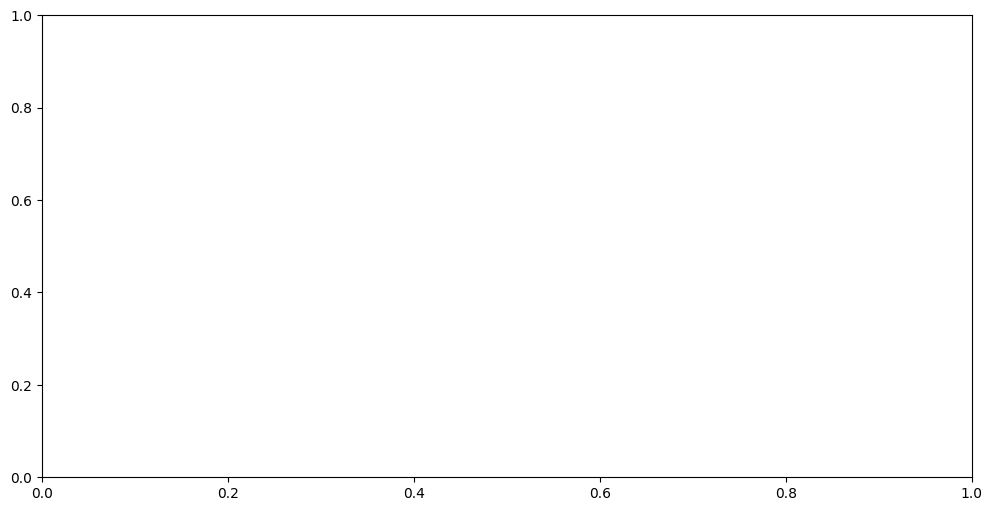

In [320]:
def PlotWeightsHistory():
  weights_hist=np.array(weights_history)
  epochs_range = range(0, num_epochs, 1)
  # Plotting SoftAdapt weights
  plt.figure(figsize=(12, 6))
  plt.plot(epochs_range, weights_hist[:,0], label='Surface Loss', alpha=.5)
  plt.plot(epochs_range, weights_hist[:,1], label='Periodic Loss', alpha=.5)
  plt.plot(epochs_range, weights_hist[:,2], label='PDE Loss', alpha=.5)
  plt.plot(epochs_range, weights_hist[:,3], label='Bottom Velocity Loss', alpha=.5)
  plt.title('SoftAdapt Weights')
  plt.xlabel('Epochs')
  plt.ylabel('Weights')
  plt.legend()
  plt.show()

PlotWeightsHistory()

#Losses plots

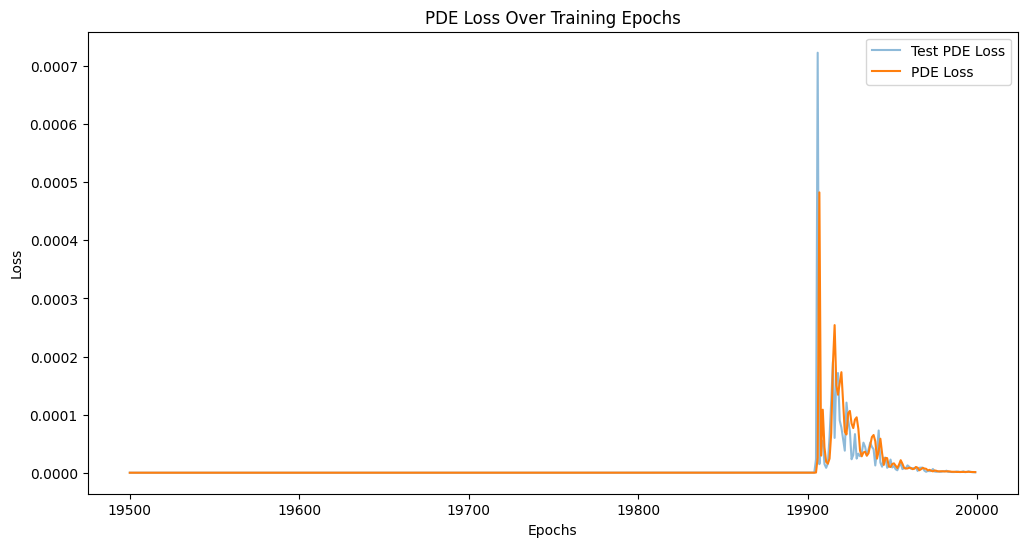

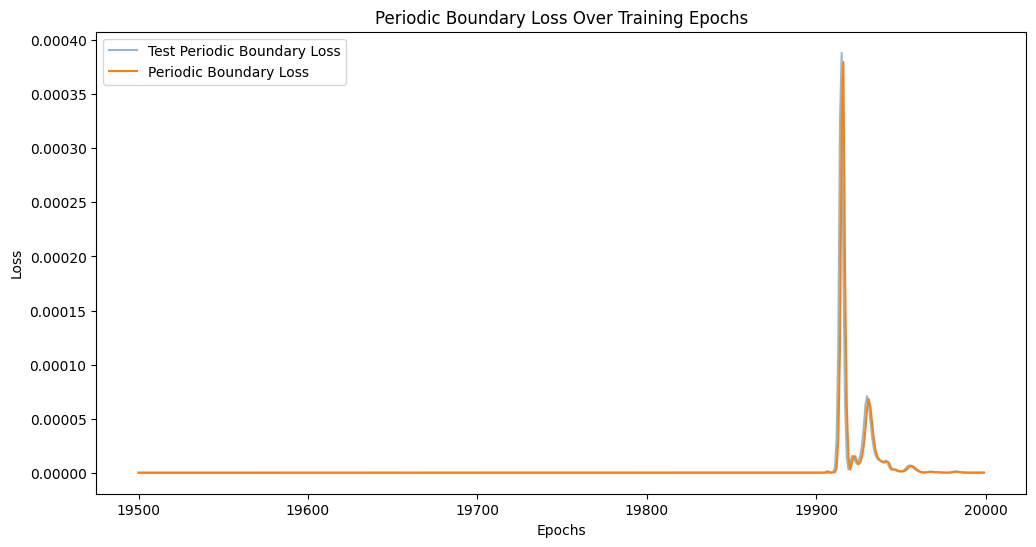

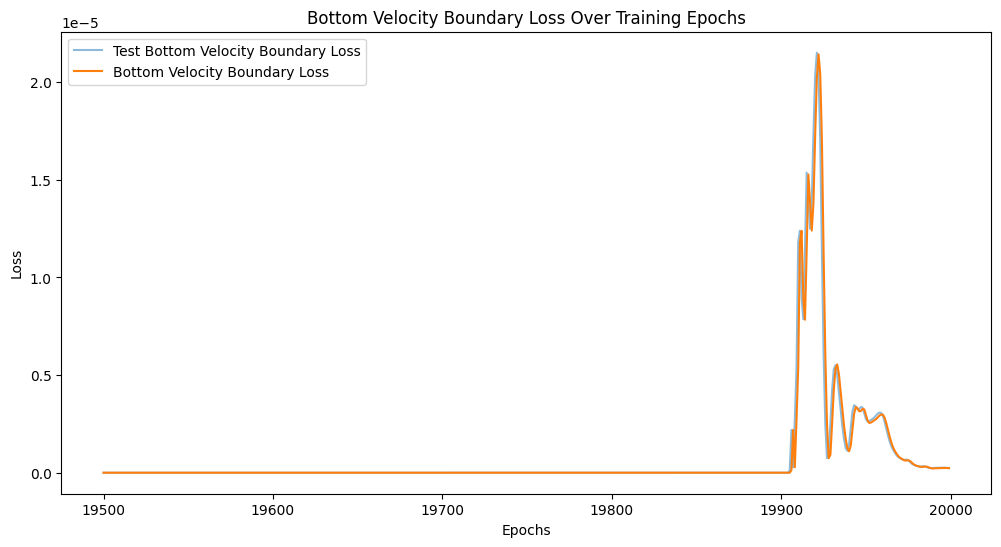

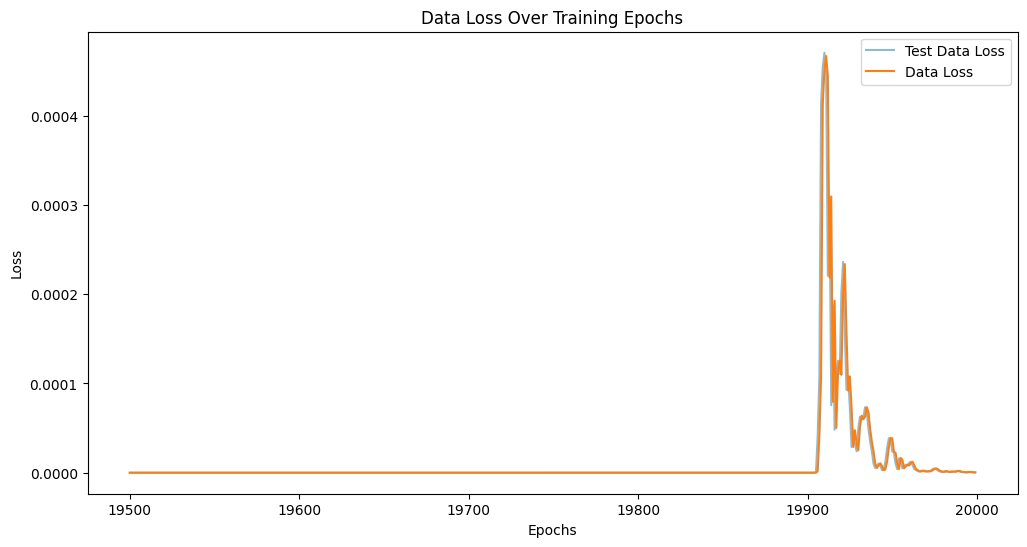

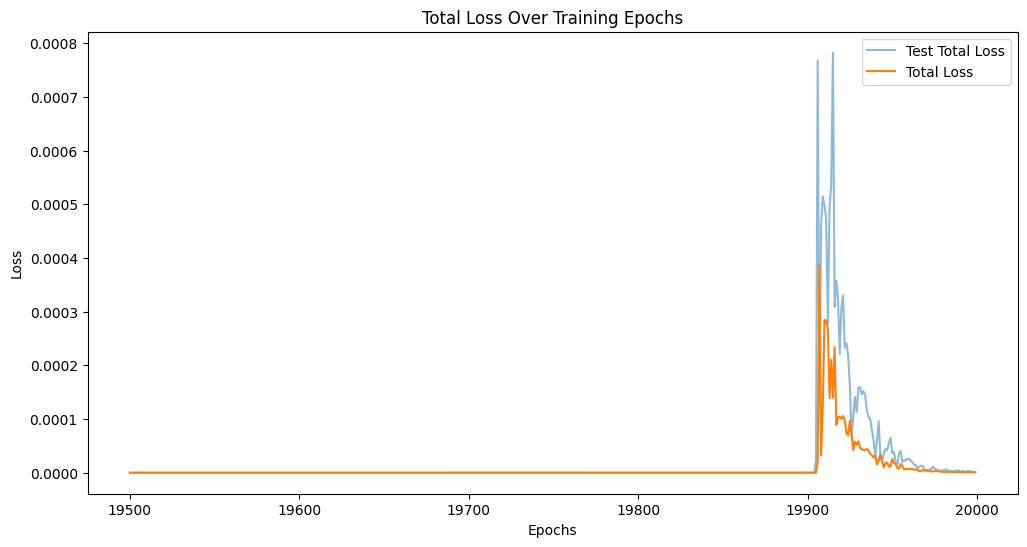

In [309]:
def plotLoss(num_epochs, start=0):
    losses = {
        "PDE Loss": [test_loss_pde_list, loss_pde_list],
        "Periodic Boundary Loss": [test_loss_per_bc_list, loss_per_bc_list],
        "Bottom Velocity Boundary Loss": [test_loss_bot_vel_bc_list, loss_bot_vel_bc_list],
        "Data Loss": [test_loss_data_list, loss_data_list],
        "Total Loss": [test_total_loss_list, total_loss_list],
    }

    epochs_range = range(start, num_epochs, 1)

    for loss_type, loss_values in losses.items():
        test_loss, training_loss = loss_values
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range, test_loss[start:num_epochs], label="Test " + loss_type, alpha=0.5)
        plt.plot(epochs_range, training_loss[start:num_epochs], label=loss_type)
        plt.title(loss_type + " Over Training Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

plotLoss(20000,19500)

#3D Plot with test data

In [321]:
def getTestData():
  total_test_data = []
  total_test_data_scaled = []
  test_data_size=288
  test_data_size_pde=144
  #generate test data
  test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
  test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
  test_input_data_pde_loss = generate_data_pde_loss(test_data_size_pde,combined=True)
  test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)

  #WARNING: the values added here must be the same as in standardized data
  total_test_data.extend(test_input_data_function_approximation)
  total_test_data.extend(test_input_data_boundary_conditions_0)
  total_test_data.extend(test_input_data_boundary_conditions_1)
  total_test_data.extend(test_input_data_pde_loss)
  total_test_data.extend(test_input_data_vel_bottom)

  #normalize data
  test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom, scaler = normalize_data(test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom,test_data_size)


  #add standardized data
  #WARINING: the values added here must be the same as above
  total_test_data_scaled.extend(test_input_data_function_approximation)
  total_test_data_scaled.extend(test_input_data_boundary_conditions_0)
  total_test_data_scaled.extend(test_input_data_boundary_conditions_1)
  total_test_data_scaled.extend(test_input_data_pde_loss)
  total_test_data_scaled.extend(test_input_data_vel_bottom)

  total_test_data = torch.Tensor(total_test_data)
  total_test_data_scaled = torch.Tensor(total_test_data_scaled)
  # Convert the list to a PyTorch tensor
  output2= model(total_test_data_scaled)


  print(output2.shape,(total_test_data_scaled.shape))
  print(total_test_data.shape)

  return total_test_data, total_test_data_scaled, output2, scaler

total_test_data, total_test_data_scaled, output2, scaler = getTestData()
x = total_test_data[:,0]
y = total_test_data[:,1]


NotFittedError: ignored

# 3d Plot Model Output

tensor([-0.0001,  0.0035,  0.0070,  ...,  0.0026,  0.0026,  0.0027],
       grad_fn=<SqueezeBackward0>)


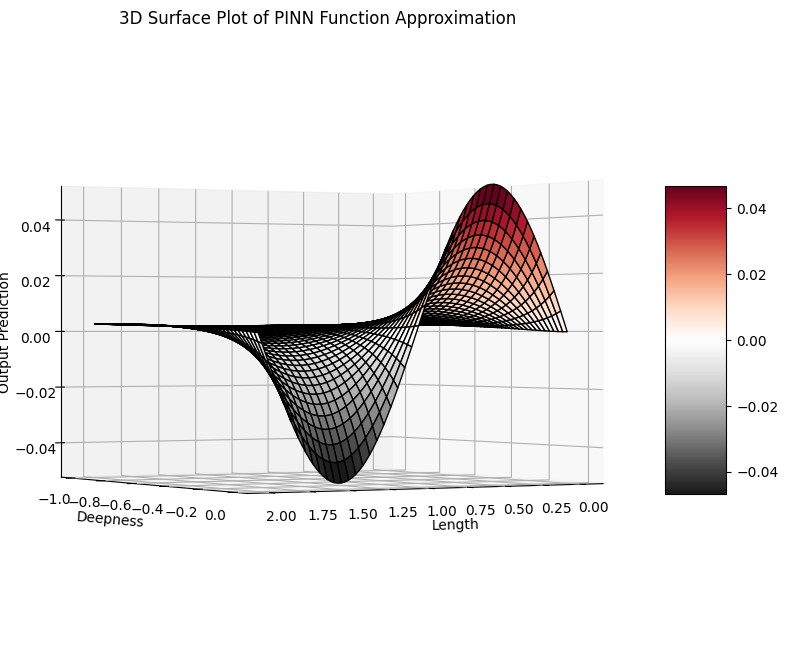

In [311]:
# Assuming your PINN output is stored in 'predicted_data_function_approximation'
# and input coordinates are stored in 'input_data_function_approximation'

x = np.linspace(0,2,90)
y = np.linspace(0,-1,90)
X,Y  = np.meshgrid(x,y)

# Stack X and Y vertically
data = np.column_stack((X.ravel(), Y.ravel()))

# Create and fit the scaler
scaled_data = scaler.transform(data)

surface_output= loaded_model(torch.Tensor(scaled_data))

print(surface_output)

# Assuming the model output is 1D, reshape it to 2D
Z = surface_output.detach().numpy().reshape(X.shape)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot

surf = ax.plot_surface(X, Y, Z, cmap='RdGy_r', edgecolor='k',)

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Deepness')
ax.set_zlabel('Output Prediction')

# Set title
ax.set_title('3D Surface Plot of PINN Function Approximation')
# Add a color bar

fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(elev=0, azim=60 )
# Show the plot
plt.show()

#3D Plot Analytical

[[ 0.          0.        ]
 [ 0.02247191  0.        ]
 [ 0.04494382  0.        ]
 ...
 [ 1.95505618 -1.        ]
 [ 1.97752809 -1.        ]
 [ 2.         -1.        ]]
[[-1.28546203  1.28891388]
 [-1.25657525  1.28891388]
 [-1.22768846  1.28891388]
 ...
 [ 1.22768846 -1.28033352]
 [ 1.25657525 -1.28033352]
 [ 1.28546203 -1.28033352]]


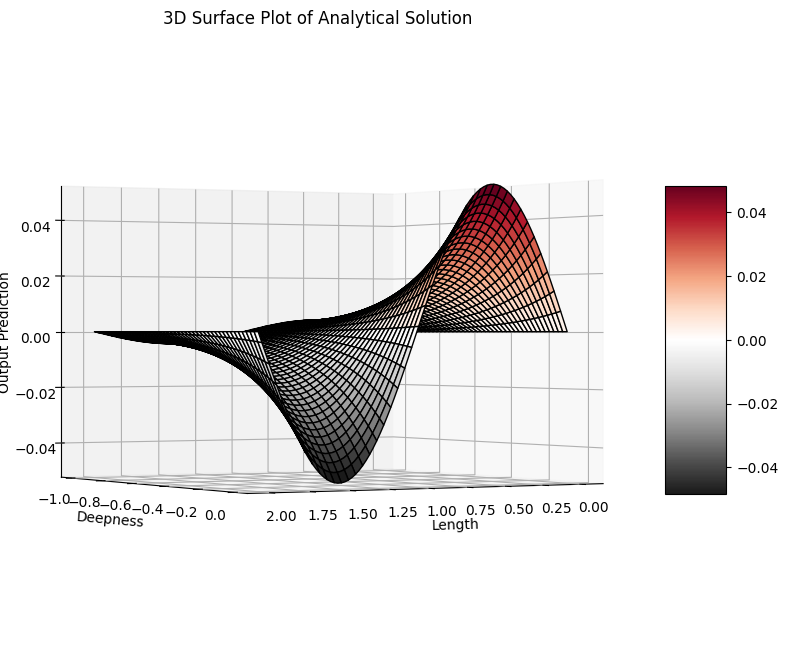

In [312]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming your PINN output is stored in 'predicted_data_function_approximation'
# and input coordinates are stored in 'input_data_function_approximation'

x = np.linspace(0,2,90)
y = np.linspace(0,-1,90)
X,Y  = np.meshgrid(x,y)

# Stack X and Y vertically
data = np.vstack([X.flatten(), Y.flatten()]).T
print(data)

scaled_data = scaler.transform(data)


print(scaled_data)


surface_output= behaviour_func(data)
# Assuming the model output is 1D, reshape it to 2D
Z = surface_output.reshape(X.shape)
#predicted_data_2d = Z.reshape(X.shape)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot

surf = ax.plot_surface(X, Y, Z, cmap='RdGy_r', edgecolor='k',)

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Deepness')
ax.set_zlabel('Output Prediction')

# Set title
ax.set_title('3D Surface Plot of Analytical Solution')
# Add a color bar

fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(elev=0, azim=60 )
# Show the plot
plt.show()

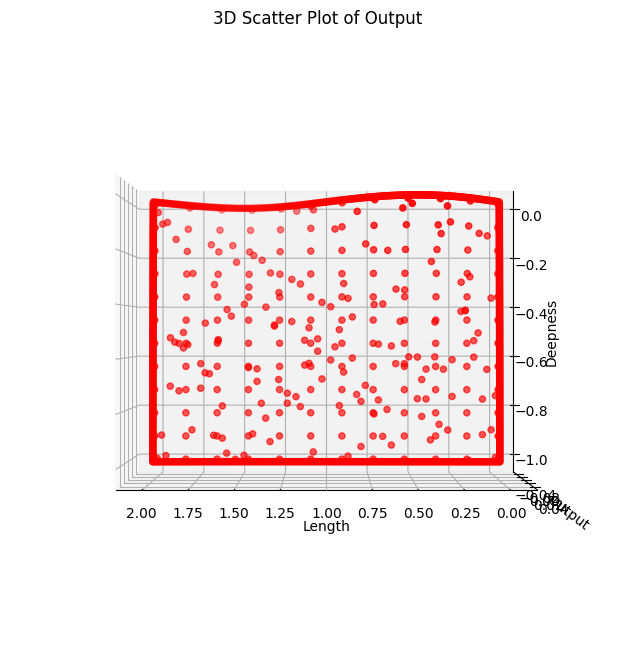

In [313]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming total_test_data[0] and total_test_data[1] are 1D arrays
x = total_test_data[:,0]
y = total_test_data[:,1]
z = output2.detach().numpy()  # Convert the torch Tensor to a NumPy array


# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x,z, y, c='r', marker='o')

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Output')
ax.set_zlabel('Deepness')

# Set title
ax.set_title('3D Scatter Plot of Output')

ax.view_init(elev=0, azim=90)  # better angle to analyze z=0
#ax.view_init(elev=0, azim=0)   #better angle to analyze periodic boundaries
# Show the plot
plt.show()


#Analytical Φ(z=0) vs Predicted Φ(z=0)

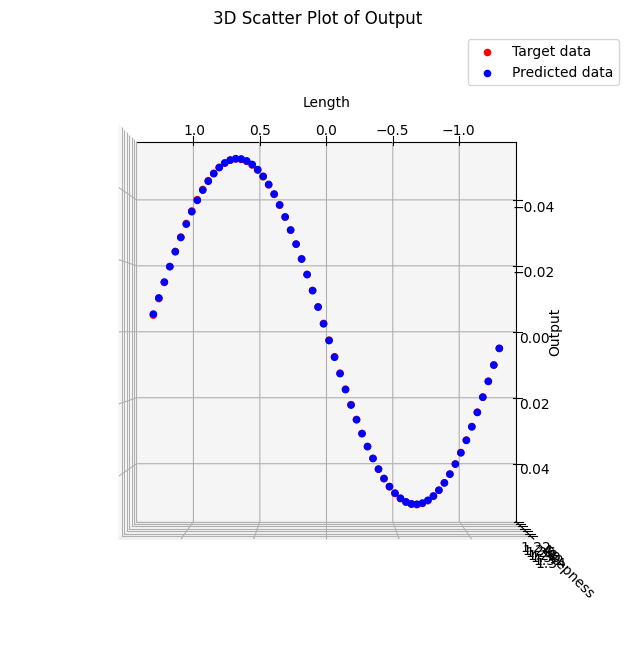

In [314]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming total_test_data[0] and total_test_data[1] are 1D arrays
x = test_input_data_function_approximation[:,0]
y = test_input_data_function_approximation[:,1]
zt = test_target_data_function_approximation  # Convert the torch Tensor to a NumPy array
zp = model(torch.Tensor(test_input_data_function_approximation))
zp= zp.detach().numpy()

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x,zt, y, c='r', marker='o', label='Target data')
ax.scatter(x,zp, y, c='b', marker='o', label='Predicted data')

ax.legend()
# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Output')
ax.set_zlabel('Deepness')

# Set title
ax.set_title('3D Scatter Plot of Output')

ax.view_init(elev=90, azim=90)  # You can adjust the elev and azim values

# Show the plot
plt.show()

In [315]:
def compute_output_grad(input):

    # Forward pass through the model
    output = model(input.requires_grad_())

    # Compute gradients with respect to both x1_tensor and x2_tensor using a single call
    grads = torch.autograd.grad(output, input, grad_outputs=torch.ones_like(output), create_graph=True)[0]

    grad_x1 = grads[:, 0]
    grad_x2 = grads[:, 1]

    return grad_x1, grad_x2

(2, 900)


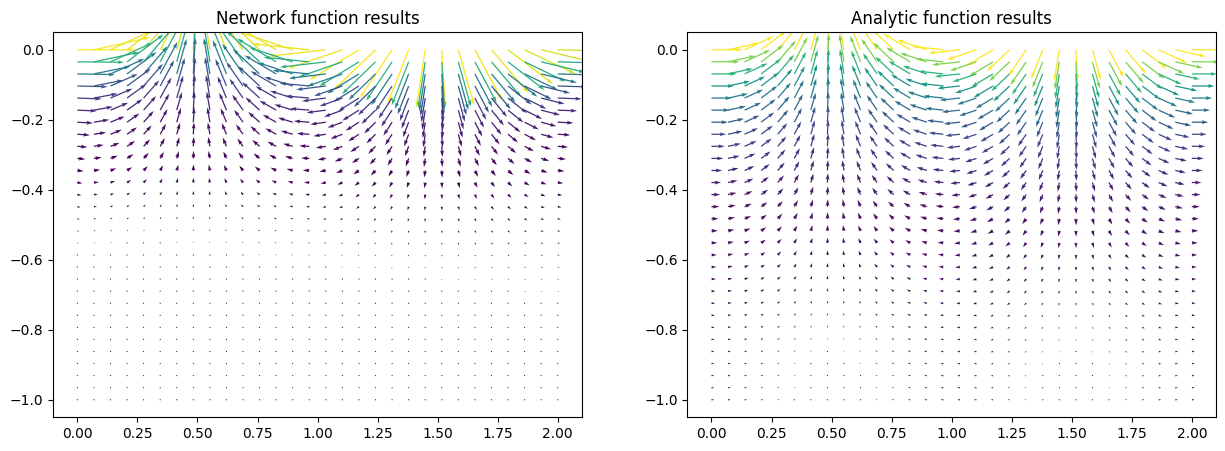

In [316]:
def compareVelocity2Analytical(body=False):
  square_top_left = (L/2 - L/16, -h/2 - L/16)
  square_width = L/8  # You can adjust the width of the square as needed
  square_height = L/8  # You can adjust the height of the square as needed

  x = np.linspace(0,2,30)
  y = np.linspace(0,-1,30)
  X,Y  = np.meshgrid(x,y)

  positions = np.vstack([X.ravel(), Y.ravel()])
  print(positions.shape)

  # Stack X and Y vertically
  data = np.vstack([X.flatten(), Y.flatten()]).T

  scaled_data = scaler.transform(data)

  # Calculate velocity of water for specific x,y direction
  u_analytic, v_analytic  = velocity_func(positions.T)
  u_network, v_network = compute_output_grad(torch.Tensor(scaled_data))
  u_network = u_network.detach().numpy()
  v_network = v_network.detach().numpy()


  fig , axs = plt.subplots(1,2, figsize = (15,5))
  axs[0].quiver(X,Y,u_network, v_network, v_network**2+u_network**2 )
  axs[0].set_title('Network function results')
  if(not body):
    axs[1].quiver(X,Y,u_analytic,v_analytic,(v_analytic**2+u_analytic**2))
    axs[1].set_title('Analytic function results')


  if(body):
  # Add the black square to both plots
    for ax in axs:
        square = plt.Rectangle(square_top_left, square_width, square_height, edgecolor='black', facecolor='black', linewidth=2)
        ax.add_patch(square)

  # Show the plot
  plt.show()


compareVelocity2Analytical()


#Model with body

##Normalize data with body data inserted

In [317]:
def normalize_data_body_inserted(data_function_approximation,data_boundary_conditions_0,data_boundary_conditions_1,data_pde_loss,data_vel_bottom,data_body_b,data_body_t,data_body_r,data_body_l,data_size,data_body_size):
  total_input_train_data=[]

  total_input_train_data.extend(data_function_approximation)
  total_input_train_data.extend(data_boundary_conditions_0)
  total_input_train_data.extend(data_boundary_conditions_1)
  total_input_train_data.extend(data_pde_loss)
  total_input_train_data.extend(data_vel_bottom)
  total_input_train_data.extend(data_body_b)
  total_input_train_data.extend(data_body_t)
  total_input_train_data.extend(data_body_r)
  total_input_train_data.extend(data_body_l)


  scaler = StandardScaler()
  total_input_train_data_scaled= scaler.fit_transform(total_input_train_data)


  input_data_function_approximation = total_input_train_data_scaled[0:data_size,:]
  input_data_boundary_conditions_0 = total_input_train_data_scaled[data_size:2*data_size,:]
  input_data_boundary_conditions_1 = total_input_train_data_scaled[2*data_size:3*data_size,:]
  input_data_pde_loss = total_input_train_data_scaled[3*data_size:4*data_size,:]
  input_data_vel_bottom = total_input_train_data_scaled[4*data_size:5*data_size,:]

  data_index= 5*data_size
  #print(data_index,data_index+data_body_size)
  input_data_body_b = total_input_train_data_scaled[data_index:data_index+data_body_size,:]
  #print(data_index +data_body_size,data_index+2*data_body_size)
  input_data_body_t = total_input_train_data_scaled[data_index+data_body_size:data_index+2*data_body_size,:]
  #print(data_index+ 2*data_body_size,data_index+3*data_body_size)
  input_data_body_r = total_input_train_data_scaled[data_index+2*data_body_size:data_index+3*data_body_size,:]
  #print(data_index+ 3*data_body_size,data_index+4*data_body_size)
  input_data_body_l = total_input_train_data_scaled[data_index+3*data_body_size:data_index+4*data_body_size,:]

  #print(input_data_body_l.shape)
  #print(data_index+3*data_body_size,data_index+4*data_body_size)


  return input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom, input_data_body_b, input_data_body_t, input_data_body_r, input_data_body_l

In [318]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Define parameters
num_epochs = 3000
learning_rate = 10**-3
momentum = 0.9
#alpha = 1.0  # Weight for data loss
#beta = 1.0   # Weight for periodic boundary condition loss
#epsilon = 1.0 # Weight for bottom velocity boundary condition loss
#gamma = 1.0  # Weight for PDE loss


# Create the model and optimizer
model = FNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

training_data_size=200
training_body_data_size=200
test_data_size=80
test_body_data_size=80

top_left_corner=[L/2-L/16,-h/2+L/16]
square_len=L/8

# Generate training data for each component of the PINN loss
input_data_function_approximation, target_data_function_approximation = generate_data_function_approximation(training_data_size)
input_data_boundary_conditions_0, input_data_boundary_conditions_1 = generate_periodic_boundary_data(training_data_size, x1_values=[0, 2])
input_data_pde_loss = generate_data_pde_loss_with_body(training_data_size,top_left_corner,square_len)
input_data_vel_bottom = generate_data_bottom_velocity(training_data_size)


input_data_body_b,input_data_body_t,input_data_body_r,input_data_body_l= generate_data_body(training_body_data_size,top_left_corner,square_len);


#normalize data
input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom, input_data_body_b,input_data_body_t,input_data_body_r,input_data_body_l = normalize_data_body_inserted(input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom,input_data_body_b,input_data_body_t,input_data_body_r,input_data_body_l,training_data_size,training_body_data_size)

# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.1)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_of_component_1 = []
values_of_component_2 = []
values_of_component_3 = []
values_of_component_4 = []
values_of_component_5 = []
# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1,1,1,1])
weights_history=[]

In [324]:
# Lists to store training losses for plotting
loss_pde_list = []
#loss_bc_list = []
loss_data_list = []
total_loss_list = []
loss_per_bc_list=[]
loss_bot_vel_bc_list=[]
loss_body_list=[]

# Lists to store test losses for plotting
test_loss_pde_list = []
#test_loss_bc_list = []
test_loss_data_list = []
test_total_loss_list = []
test_loss_per_bc_list=[]
test_loss_bot_vel_bc_list=[]
test_loss_body_list=[]

# Training loop
for epoch in range(num_epochs):


    # Forward pass for each component
    predicted_data_function_approximation = loaded_model(torch.from_numpy(input_data_function_approximation).float())

    # Compute losses
    loss_function_approximation = data_loss(predicted_data_function_approximation, torch.Tensor(target_data_function_approximation).float())

    boundary_conditions = {
      'bc1': compute_bc1(model, input_data_vel_bottom[:,0], input_data_vel_bottom[:,1]),   # at x2=-1 the grad perpendicular to the bottom is null
      'bc2_0': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_0)),  # at x1 = 0
      'bc2_1': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_1)),  # at x1 = 2
      'bc_body_t':compute_bc1(model, input_data_body_t[:,0], input_data_body_t[:, 1]),
      'bc_body_b':compute_bc1(model, input_data_body_b[:, 0], input_data_body_b[:, 1]),
      'bc_body_r':compute_bc3(model, input_data_body_r[:, 0], input_data_body_r[:, 1]),
      'bc_body_l':compute_bc3(model, input_data_body_l[:, 0], input_data_body_l[:, 1]),
    }

    #loss_boundary_conditions = beta* boundary_condition_loss(boundary_conditions,predicted_data_function_approximation)

    loss_periodic_boundary = periodic_boundary_loss(boundary_conditions)

    loss_pde_loss= pde_loss(model,torch.tensor(input_data_pde_loss, requires_grad = True, dtype=torch.float))

    loss_vel_bottom_boundary = bottom_velocity_boundary_loss(boundary_conditions,predicted_data_function_approximation)

    loss_body= body_boundary_loss(boundary_conditions,predicted_data_function_approximation); #WARNING: if data_size != data_body_size, we need a different array


    # Keeping track of each loss component
    values_of_component_1.append(loss_function_approximation)
    values_of_component_2.append( loss_periodic_boundary )
    values_of_component_3.append(loss_pde_loss)
    values_of_component_4.append(loss_vel_bottom_boundary)
    values_of_component_5.append(loss_body)


    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1),
                                                                 torch.tensor(values_of_component_2),
                                                                 torch.tensor(values_of_component_3),
                                                                torch.tensor(values_of_component_4),
                                                               torch.tensor(values_of_component_5),
                                                                 verbose=False,
                                                                   )
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
        values_of_component_3 = []
        values_of_component_4 = []
        values_of_component_5 = []



    # Total loss
    #total_loss = loss_function_approximation + loss_boundary_conditions + loss_pde_loss

    #total_loss = loss_function_approximation + loss_periodic_boundary + loss_vel_bottom_boundary + loss_pde_loss

    total_loss = adapt_weights[0] * loss_function_approximation + 10*adapt_weights[1]*loss_periodic_boundary + 10*adapt_weights[2]*loss_pde_loss + adapt_weights[3]*loss_vel_bottom_boundary + adapt_weights[4]*loss_body
    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    weights_history.append(adapt_weights.numpy())


    # Append losses to the lists
    loss_pde_list.append(loss_pde_loss.item())
    #loss_bc_list.append(loss_boundary_conditions.item())
    loss_per_bc_list.append(loss_periodic_boundary.item())
    loss_bot_vel_bc_list.append(loss_vel_bottom_boundary.item())
    loss_data_list.append(loss_function_approximation.item())
    loss_body_list.append(loss_body.item()) #body loss
    total_loss_list.append(total_loss.item())

    # Generate test data for each component of the PINN loss
    test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
    test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
    test_input_data_pde_loss = generate_data_pde_loss_with_body(test_data_size,top_left_corner,square_len)
    test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)
    test_input_data_body_b,test_input_data_body_t,test_input_data_body_r,test_input_data_body_l= generate_data_body(test_body_data_size,top_left_corner,square_len);

    #print(test_input_data_body_l.shape)

    #normalize data
    test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom, test_input_data_body_b,test_input_data_body_t,test_input_data_body_r,test_input_data_body_l = normalize_data_body_inserted(test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom, test_input_data_body_b,test_input_data_body_t,test_input_data_body_r,test_input_data_body_l,test_data_size,test_body_data_size)

    #print(test_input_data_body_l.shape)
    # Test loop
    # Forward pass for each component
    test_predicted_data_function_approximation = model(torch.Tensor(test_input_data_function_approximation))

    # Compute test losses
    test_loss_function_approximation = data_loss(test_predicted_data_function_approximation, torch.Tensor(test_target_data_function_approximation))

    test_boundary_conditions = {
        'bc1': compute_bc1(model, test_input_data_vel_bottom[:, 0], test_input_data_vel_bottom[:, 1]),
        'bc2_0': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_0)),
        'bc2_1': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_1)),
        'bc_body_t':compute_bc1(model, test_input_data_body_t[:,0], test_input_data_body_t[:, 1]),
        'bc_body_b':compute_bc1(model, test_input_data_body_b[:, 0], test_input_data_body_b[:, 1]),
        'bc_body_r':compute_bc3(model, test_input_data_body_r[:, 0], test_input_data_body_r[:, 1]),
        'bc_body_l':compute_bc3(model, test_input_data_body_l[:, 0], test_input_data_body_l[:, 1]),
    }

    #test_loss_boundary_conditions = beta*boundary_condition_loss(test_boundary_conditions, test_predicted_data_function_approximation)

    test_loss_periodic_boundary = periodic_boundary_loss(test_boundary_conditions)

    test_loss_vel_bottom_boundary = bottom_velocity_boundary_loss(test_boundary_conditions,test_predicted_data_function_approximation)

    test_loss_pde_loss = pde_loss(model, torch.tensor(test_input_data_pde_loss, requires_grad = True, dtype=torch.float))

    test_loss_body= body_boundary_loss(test_boundary_conditions,test_predicted_data_function_approximation); #WARNING: if data_size != data_body_size, we need a different array

    # Total test loss
    #test_total_loss = test_loss_function_approximation + test_loss_boundary_conditions + test_loss_pde_loss
    test_total_loss = test_loss_function_approximation + test_loss_periodic_boundary + test_loss_vel_bottom_boundary + test_loss_pde_loss

    # Append test losses to the lists
    test_loss_pde_list.append(test_loss_pde_loss.item())
    #test_loss_bc_list.append(test_loss_boundary_conditions.item())
    test_loss_bot_vel_bc_list.append(test_loss_vel_bottom_boundary.item())
    test_loss_per_bc_list.append(test_loss_periodic_boundary.item())
    test_loss_data_list.append(test_loss_function_approximation.item())
    test_loss_body_list.append(test_loss_body.item()) #body loss
    test_total_loss_list.append(test_total_loss.item())

    # Print loss for monitoring
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs},train PDE Loss: {loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},train Boundaries Loss: {loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},train Periodic Boundary Loss: {loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Bottom Velocity Boundary Loss: {loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Data Loss: {loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},train Body Loss: {loss_body}')
        print(f'Epoch {epoch}/{num_epochs},train Total Loss: {total_loss.item()}')
        print("------------------------------------------------------------")
        print(f'Epoch {epoch}/{num_epochs},test PDE Loss: {test_loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},test Boundaries Loss: {test_loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},test Periodic Boundary Loss: {test_loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Bottom Velocity Boundary Loss: {test_loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Data Loss: {test_loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},test Body Loss: {test_loss_body}')
        print(f'Epoch {epoch}/{num_epochs},test Total Loss: {test_total_loss.item()}')
        print("#############################################################")
        print("#############################################################")
# After training, you can use the trained model for predictions or further analysis


Epoch 0/3000,train PDE Loss: 2.886077481889515e-06
Epoch 0/3000,train Periodic Boundary Loss: 1.3116120953782229e-06
Epoch 0/3000,train Bottom Velocity Boundary Loss: 1.048166041073273e-06
Epoch 0/3000,train Data Loss: 0.0011218695435672998
Epoch 0/3000,train Body Loss: 1.0014256076829042e-05
Epoch 0/3000,train Total Loss: 0.0003981275323436308
------------------------------------------------------------
Epoch 0/3000,test PDE Loss: 5.229272119322559e-06
Epoch 0/3000,test Periodic Boundary Loss: 1.5407910041176365e-06
Epoch 0/3000,test Bottom Velocity Boundary Loss: 1.0368304401708883e-06
Epoch 0/3000,test Data Loss: 1.6252966815955006e-05
Epoch 0/3000,test Body Loss: 9.210041753249243e-06
Epoch 0/3000,test Total Loss: 2.4059861971181817e-05
#############################################################
#############################################################


ValueError: ignored

In [ ]:
print(weights_hist[:,0])

In [ ]:
PlotWeightsHistory()

In [ ]:
plotLoss(num_epochs)

In [ ]:
compareVelocity2Analytical(True)